In [188]:
import numpy as np 
import pandas as pd 
import sklearn as sk 
import matplotlib.pyplot as plt 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

## Data Cleaning/Manipulation

In [222]:
## Read Data and subset those who have valid response 
data = pd.read_csv('Train.csv')
default_na_index = np.where(data['IsDefaulted'].isna())[0]
working_data = data[~data.index.isin(default_na_index)]
## Check other columns, seems to be a systematic removal of variables
# working_data.isna().sum()

In [223]:
## Drop ID columns 
working_data = working_data.drop(columns = ['CustomerId', 'TransactionStartTime','TransactionId','BatchId', 'ProviderId','SubscriptionId', 'ChannelId', 
                                                'InvestorId', 'LoanApplicationId', 'LoanId','ThirdPartyId', 'PayBackId'])
## Set date columns as pd.date
working_data[['IssuedDateLoan', 'PaidOnDate', 'DueDate']] = working_data[['IssuedDateLoan', 'PaidOnDate', 'DueDate']].apply(pd.to_datetime)

In [224]:
## Look at how the difference in how long people take to pay back loans (Feature Extraction)
default_ind = working_data['IsDefaulted']
issued_dates = pd.to_datetime(working_data['IssuedDateLoan'])
paid_dates= pd.to_datetime(working_data['PaidOnDate'])
length_topay = paid_dates - issued_dates
length_topay = length_topay.dt.days 
print('average days to pay loan for non-defaulter is ' ,np.mean(length_topay[default_ind[default_ind==0].index]))
print('average days to pay loan for defaulter is ', np.mean(length_topay[default_ind[default_ind == 1].index]))

average days to pay loan for non-defaulter is  23.470229007633588
average days to pay loan for defaulter is  39.13483146067416


In [225]:
## Create the features itself 
working_data['PayLoanTime'] = (pd.to_datetime(working_data['PaidOnDate']) - pd.to_datetime(working_data['IssuedDateLoan'])).dt.days

In [226]:
## For nd the numerical columns, which ones are significantly different between those who default and who do not? 
## Do a t-test of differences for the numerical variables to get a t-statistic 
numerical = working_data.select_dtypes(include=['float64', 'int64'])
rest = numerical.loc[:,numerical.columns != 'IsDefaulted' ]
default_ind = numerical['IsDefaulted']

default_index = default_ind[default_ind == 1.0].index
ndefault_index = default_ind[default_ind == 0.0].index
rest_d =  rest.loc[default_index]
rest_nd = rest.loc[ndefault_index]
## Take mean of each predictor 
d_mean = np.mean(rest_d)
nd_mean = np.mean(rest_nd)
## Take SD of each predictor
d_sd = np.std(rest_d)**2
nd_sd = np.std(rest_nd)**2
# n = len(rest_d)
## Calculate t-statistic/test based on given notes:  
t_statistic = (nd_mean - d_mean) / ((d_sd/len(rest_d)) + (nd_sd/len(rest_nd))) **.5
t_statistic = abs(t_statistic)
## Rank nd t values
t_rank = t_statistic.sort_values(ascending = False) 
print(t_rank[0:10])

IsFinalPayBack           57.242439
Amount                   19.449939
Value                    19.441983
PayLoanTime               4.791926
AmountLoan                2.789383
IsThirdPartyConfirmed     0.811902
CountryCode                    NaN
TransactionStatus              NaN
dtype: float64


CountryCode and Transaction Status have no difference (all defaulters and non-defaulters have the same values for these two categories). So I will drop them from the working data set. It is also noted that the variable IsThirdParty Confirmed is also not significantly different among the two groups.

In [211]:
working_data = working_data.drop(columns = ['CountryCode', 'TransactionStatus'])

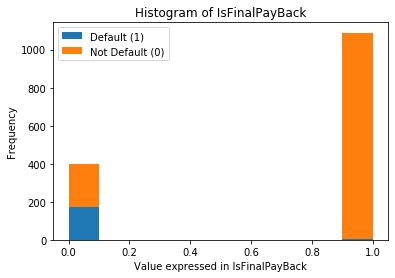

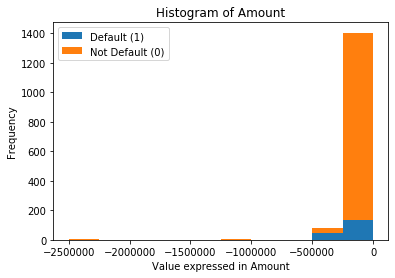

In [232]:
## Visualize the top factors, IsFinalPayBack, Value Amount, PayLoanTime 
best_predictor = 'IsFinalPayBack'
##Train Data plot
plt.xlabel('Value expressed in IsFinalPayBack')
plt.ylabel('Frequency')
plt.title('Histogram of IsFinalPayBack')
plt.hist([rest_d[best_predictor].values, rest_nd[best_predictor].values], stacked = True)
plt.legend(('Default (1)', 'Not Default (0)'))

plt.figure(2)
second_predictor = 'Amount'
plt.xlabel('Value expressed in Amount')
plt.ylabel('Frequency')
plt.title('Histogram of Amount')
plt.hist([rest_d[second_predictor].values, rest_nd[second_predictor].values], stacked = True)
plt.legend(('Default (1)', 'Not Default (0)'))

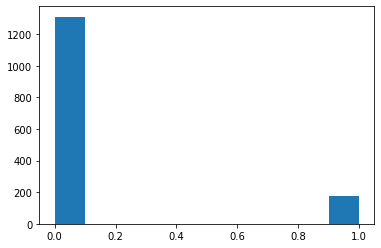

In [160]:
## Clear misrepresentation in the training set 
plot = plt.hist(working_data['IsDefaulted'])

In [233]:
# downsampled = resample(working_data[working_data['IsDefaulted']== 0], n_samples = 500, replace= False)
# upsampled = resample(working_data[working_data['IsDefaulted'] == 1], n_samples = 500, replace = True)

In [240]:
# train = pd.concat([downsampled, upsampled], axis = 0)
train = working_data
## Create categorical/binary features 
categorical_cols = train.iloc[:, np.where(train.dtypes == 'object')[0]].columns
uniques_type = [len(pd.unique(train[i])) for i in categorical_cols] 
new_dummies = []
for count,length in enumerate(uniques_type):
    if length  == 2: 
        train[categorical_cols[count]] = [1 if j == pd.unique(j)[0] else 0 for j in train[categorical_cols[count]]]  
    else:  
         new_dummies.append(pd.get_dummies(train[categorical_cols[count]]))
## Create a new trainframe of all the categorical variables 
d = {k:v for k,v in enumerate(new_dummies)}
# Store column names
col = []
for key, item in d.items():
    col.append(item.columns)
col_names = [item for sublist in col for item in sublist]
categorical = pd.concat(d, axis = 1, ignore_index = True)
## Append categorical variables to working trainset
categorical.columns = col_names
full_train = pd.concat([train, categorical], axis =1)
## Drop original categorical columns 
full_train = full_train.drop(columns = categorical_cols)
y = full_train['IsDefaulted']
x = full_train.drop(columns = ['IsDefaulted'])
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = .2)

In [241]:
## Drop All Dates for Now
x_train = x_train.drop(columns = (x_train.columns[np.where(x_train.dtypes == 'datetime64[ns]')[0]]))
x_test = x_test.drop(columns = (x_test.columns[np.where(x_test.dtypes == 'datetime64[ns]')[0]]))

## Simple Logistic Model (LogisticRegressionCV)

In [242]:
log = LogisticRegressionCV(cv = 5)
simple_logistic = log.fit(x_train, y_train)
print('simple logistic train accuracy score is ', accuracy_score(y_train, simple_logistic.predict(x_train)))
print('simple logisic test accuracy score is ', accuracy_score(y_test, simple_logistic.predict(x_test)))
confusion_matrix(y_test, simple_logistic.predict(x_test))
print('simple logistic test auc score is ', roc_auc_score(y_test, simple_logistic.predict(x_test)))

simple logistic train accuracy score is  0.8890756302521008
simple logisic test accuracy score is  0.8758389261744967
simple logistic test auc score is  0.6018711018711019
